# Linear Layer

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from sklearn import model_selection
import torch.nn.functional as F
import numpy as np

# Load the dataset
df = pd.read_csv('27-06-all-crop.csv')  # Replace "your_dataset.csv" with the actual path to your dataset
df.shape

(5094, 13)

In [2]:
# map the classification columns
agzone_map = {
    "NSW VH3": 0,
    "NSW H1": 1,
    "NSW H2": 2,
    "NSW H3": 3,
    "VIC H1": 4,
    "VIC H2": 5,
    "WA H1": 6,
    "WA H2": 7,
    "WA H3": 8,
    "WA H4": 9,
    "WA H5": 10,
    "WA H5W": 11,
    "WA M1": 12,
    "WA M2": 13,
    "WA M3": 14,
    "WA M4": 15,
    "WA M5": 16,
    "NSW M2": 17,
    "NSW M3": 18,
    "VIC M1": 19,
    "VIC M2": 20,
    "WA L1": 21,
    "WA L2": 22,
    "WA L3": 23,
    "WA L4": 24,
    "WA L5": 25,
    "NSW L3": 26,
}
name_map = {
    "ChickpeaKabul": 0,
    "AdzukiBean": 1,
    "Lupin": 2,
    "Lucerne": 3,
    "Silage": 4,
    "FabaBean": 5,
    "OtherHay": 6,
    "Vetch": 7,
    "OatenHay": 8,
    "Triticale": 9,
    "CerealRye": 10,
    "FeedBarley": 11,
    "Wheat": 12,
    "OtherCrop": 13,
    "Oat": 14,
    "MaltBarley": 15,
    "Lentil": 16,
    "Canola": 17,
    "AlbusLupin": 18,
    "Sunflower": 19,
    "CanolaGm": 20,
    "Rice": 21,
    "Sorghum": 22,
    "MaizeOrCorn": 23,
    "ChickpeaDesi": 24,
    "FieldPea": 25,
    "Cotton": 26
}

df["Agzone"] = df["Agzone"].map(agzone_map).astype(int)
df["Name"] = df["Name"].map(name_map).astype(int)

df.shape

(5094, 13)

In [3]:
# group data
number_of_years = 4
grouped_df = df.groupby(['ProfitSeriesBusinessId', 'Name'])
filtered_df = grouped_df.filter(lambda group_data: (~group_data['Year'].duplicated()).all() and len(group_data['Year']) >= number_of_years)

sorted_df = filtered_df.groupby('ProfitSeriesBusinessId').apply(lambda x: x.sort_values('Year'))
sorted_df = sorted_df.reset_index(drop=True)

# Convert each group to a list of dictionaries
grouped_list = [group.to_dict(orient='records') for _, group in sorted_df.groupby(['ProfitSeriesBusinessId','Name'])]

# Group into 3's
combinations = []
for group in grouped_list:
    [combinations.append(group[i:i+number_of_years]) for i in range(len(group)-(number_of_years-1))]

In [4]:
# map each data vector
excluded_keys = ['Name', 'ProfitSeriesBusinessId', 'Id', 'Agzone', 'Year']

regression_data = []
name_data = []
agzone_data = []
targets = []
for combination in combinations:
    combined_dict = {}
    for row in combination:
        filtered_row = {key: value for key, value in row.items() if key not in excluded_keys}
        for key, value in filtered_row.items():
            combined_key = key + str(row['Year'])
            combined_dict[combined_key] = value

    current_year = max(combination, key=lambda x: x['Year'])['Year']
    
    targets.append(combined_dict[f"YieldTonnesPerHa{current_year}"])
    del combined_dict[f"YieldTonnesPerHa{current_year}"]
    del combined_dict[f"WUE_KgPerHa{current_year}"]
    
    regression_data.append(combined_dict)
    name_data.append(combination[0]['Name'])
    agzone_data.append(combination[0]['Agzone'])

In [5]:
# convert data to lists
X_regression = []

for dictionary in regression_data:
    values = list(dictionary.values())
    X_regression.append(values)

In [6]:
def create_one_hot_layer(features, num_classes):
    return F.one_hot(features, num_classes)

one_hot_agzone = create_one_hot_layer(features=torch.tensor(agzone_data), num_classes=27)
one_hot_name = create_one_hot_layer(features=torch.tensor(name_data), num_classes=27)

X_regression = np.concatenate((X_regression, one_hot_agzone, one_hot_name), axis=1)

In [7]:
# Splitting regression features
X_train_regression, X_test_regression, y_train, y_test = model_selection.train_test_split(
    torch.tensor(X_regression, dtype=torch.float32), targets, test_size=0.2, random_state=42)

X_val_regression, X_test_regression, y_val, y_test = model_selection.train_test_split(
    X_test_regression, y_test, test_size=0.5, random_state=42)

In [8]:
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)
y_val = y_val.unsqueeze(1)

In [9]:
print("Train:")
print(X_train_regression.shape)

print("Val:")
print(X_val_regression.shape)

print("Test:")
print(X_test_regression.shape)

regression_input_size = X_train_regression.size(1)

Train:
torch.Size([244, 84])
Val:
torch.Size([30, 84])
Test:
torch.Size([31, 84])


In [10]:
class Model(nn.Module):
    def __init__(self, regression_input_size):
        super(Model, self).__init__()

        self.output_layer = nn.Linear(regression_input_size, 1)

    def forward(self, regression_inputs):
        return self.output_layer(regression_inputs)

In [11]:
# Creating an instance of the model
model = Model(regression_input_size)

print(model)

Model(
  (output_layer): Linear(in_features=84, out_features=1, bias=True)
)


In [12]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [13]:
train_losses = []
val_losses = []

In [14]:
best_val_loss = float('inf')
patience = 5000
counter = 0
append_counter = 0
batch_size = 244

In [15]:
for epoch in range(1000000):
    # Randomly select a batch of {batch_size} samples from the training data
    indices = random.sample(range(len(X_train_regression)), batch_size)
    X_train_regression_batch = X_train_regression[indices]
    y_train_batch = y_train[indices]

    # Forward pass
    y_pred_train = model.forward(X_train_regression_batch)
    y_pred_val = model(X_val_regression)

    # Compute loss
    train_loss = loss_fn(y_pred_train, y_train_batch)
    val_loss = loss_fn(y_pred_val, y_val)

#     Calculate the regularization loss
    regularization_loss = 0.0
    for param in model.parameters():
        regularization_loss += torch.sum(param**2) 
        
    train_loss += regularization_loss * 0.001

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass
    train_loss.backward()

    # Update weights
    optimizer.step()

    append_counter += 1
    if append_counter == 1000:
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        append_counter = 0
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    

    # Check if val loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    # Check if we have reached the patience limit
    if counter >= patience:
        print(f'Validation loss has not improved for {patience} epochs. Stopping early.')
        break

Epoch 1000, Train Loss: 1076.8993, Validation Loss: 1552.2439
Epoch 2000, Train Loss: 834.4731, Validation Loss: 1238.1975
Epoch 3000, Train Loss: 634.8795, Validation Loss: 992.1647
Epoch 4000, Train Loss: 481.3576, Validation Loss: 785.3533
Epoch 5000, Train Loss: 362.2617, Validation Loss: 601.4968
Epoch 6000, Train Loss: 264.5761, Validation Loss: 434.8171
Epoch 7000, Train Loss: 183.7758, Validation Loss: 295.3921
Epoch 8000, Train Loss: 119.7805, Validation Loss: 188.5149
Epoch 9000, Train Loss: 71.8698, Validation Loss: 111.3291
Epoch 10000, Train Loss: 38.5312, Validation Loss: 58.9270
Epoch 11000, Train Loss: 17.7145, Validation Loss: 26.5086
Epoch 12000, Train Loss: 6.7322, Validation Loss: 9.4376
Epoch 13000, Train Loss: 2.3216, Validation Loss: 2.6531
Epoch 14000, Train Loss: 1.0880, Validation Loss: 0.8913
Epoch 15000, Train Loss: 0.7553, Validation Loss: 0.5607
Epoch 16000, Train Loss: 0.6022, Validation Loss: 0.4884
Epoch 17000, Train Loss: 0.5209, Validation Loss: 0.470

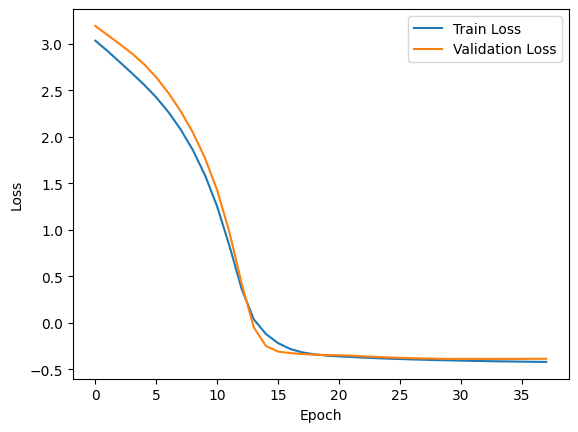

In [16]:
# Plot the training and validation loss over each epoch
plt.plot(torch.tensor(train_losses).log10(), label='Train Loss')
plt.plot(torch.tensor(val_losses).log10(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction:  torch.Size([31, 1])
y_test:  torch.Size([31, 1])


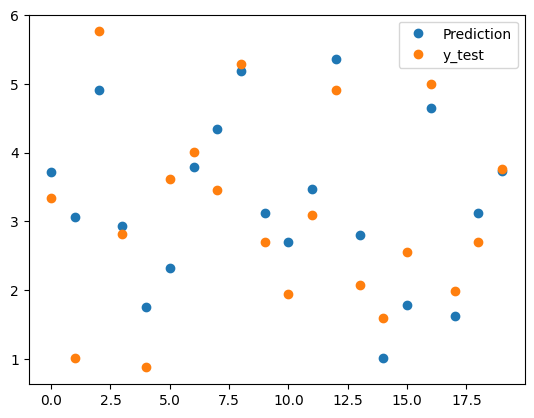

In [17]:
# Forward pass on test data
y_pred = model(X_test_regression)

prediction = y_pred.tolist()

print("Prediction: ", y_pred.size())
print("y_test: ", y_test.size())


plt.plot(prediction[0:20], 'o', label='Prediction')
plt.plot(y_test[0:20].detach().numpy(), 'o', label='y_test')

plt.legend()
plt.show()

In [18]:
# Convert tensors to numpy arrays
prediction = np.array(prediction)
y_test = y_test.numpy()

# Calculate the absolute differences between predictions and true values
abs_diff = np.abs(prediction - y_test)

# Calculate the mean absolute error
mae = np.mean(abs_diff)

print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.6158384161610757
